# Performance of the LM models

In [84]:
import csv
from tqdm import tqdm
import torch
from transformers import pipeline
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
def get_data(data_dir):
    f = open(data_dir)
    reader = csv.DictReader(f)

    targets = []
    sentences = []
    for row in reader:
        sentence = row['sentence']
        target = row['answer']
        
        targets.append(target)
        sentences.append(sentence)

    return sentences, targets


def generate(model, text, tokenizer, n=10):
    # text = 'his name is Henry , her name is Mary , my name is Twyla and your name is Geneva . his name is'
    input_ids = torch.tensor([tokenizer.encode(text)]).to(device)
    output = model.generate(
        input_ids,
        do_sample = True, 
        max_length = len(input_ids[0]) + 1, 
        top_k = 50, 
        top_p = 0.95, 
        num_return_sequences = n
    )
    answers = tokenizer.decode(output[:,-1], skip_special_tokens = True)

    return answers

def eval(model, texts, targets, verbose = False):
    total = 0
    correct = 0
    errors = []

    if "roberta" in model:
        texts = [text.replace("[MASK]", "<mask>") for text in texts]
    elif "gpt" in model:
        texts = [text.replace(" [MASK] .", "") for text in texts]

    if "bert" in model:
        if torch.cuda.is_available():
            x = 0
        else:
            x = -1
        predict = pipeline('fill-mask', model = model, device = x)
        for text, target in tqdm(zip(texts, targets)):
            total += 1
            pred = predict(text)[0]
            pred = pred["token_str"]
            if pred.strip().lower() == target.strip().lower():
                correct += 1
            else:
                errors.append(target)
            if verbose: 
                print(text, pred, target)

    elif "gpt" in model:
        tokenizer = GPT2Tokenizer.from_pretrained(model)
        model = GPT2LMHeadModel.from_pretrained(model, pad_token_id=tokenizer.eos_token_id).to(device)
        for text, target in tqdm(zip(texts, targets)):
            total += 1
            preds = generate(model, text, tokenizer, n=1)
            if target.strip().lower() in preds.lower():
                correct += 1
            else:
                errors.append(target)
            if verbose: 
                print(target, preds)

    return correct/total, errors

## Name to entity

In [5]:
def main():
    models = ["bert-base-uncased", "roberta-base",
              "bert-large-uncased", "roberta-large", 
              "gpt2", "gpt2-medium"] 
    fieldnames = ["model", 0, 1, 2, 3]
    results = []

    data_dir = './'
    out_dir = data_dir + "name_results.csv"

    for model in models:
        print(f"{model}:\n" + 100 * '-')
        result = dict.fromkeys(fieldnames)
        result["model"] = model
        for n in [0, 1, 2, 3]:
            print(f"n={n}:\n" + 100 * '-')
            f = data_dir + f"name_num_attractors_{n}.csv"
            texts,targets = get_data(f)
            acc, err = eval(model, texts, targets, verbose = False)
            result[n] = acc
        results.append(result)
        print(results)

    with open(out_dir, 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(results)


In [6]:
main()

bert-base-uncased:
----------------------------------------------------------------------------------------------------
n=0:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
369it [00:24, 15.28it/s]


n=1:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
186it [00:13, 13.56it/s]


n=2:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
186it [00:15, 11.64it/s]


n=3:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
186it [00:17, 10.40it/s]


[{'model': 'bert-base-uncased', 0: 1.0, 1: 0.967741935483871, 2: 0.5967741935483871, 3: 0.6290322580645161}]
roberta-base:
----------------------------------------------------------------------------------------------------
n=0:
----------------------------------------------------------------------------------------------------


369it [00:25, 14.64it/s]


n=1:
----------------------------------------------------------------------------------------------------


186it [00:14, 12.41it/s]


n=2:
----------------------------------------------------------------------------------------------------


186it [00:17, 10.72it/s]


n=3:
----------------------------------------------------------------------------------------------------


186it [00:19,  9.57it/s]

[{'model': 'bert-base-uncased', 0: 1.0, 1: 0.967741935483871, 2: 0.5967741935483871, 3: 0.6290322580645161}, {'model': 'roberta-base', 0: 1.0, 1: 1.0, 2: 0.7580645161290323, 3: 0.5913978494623656}]


## Parent-child

In [9]:
def main():
    models = ["bert-base-uncased", "roberta-base",
              "bert-large-uncased", "roberta-large", 
              "gpt2", "gpt2-medium"] 
    fieldnames = ["model", 0, 1, 2, 3]
    results = []

    data_dir = './'
    out_dir = data_dir + "parents_results.csv"

    for model in models:
        print(f"{model}:\n" + 100 * '-')
        result = dict.fromkeys(fieldnames)
        result["model"] = model
        for n in [0, 1, 2, 3]:
            print(f"n={n}:\n" + 100 * '-')
            f = data_dir + f"parents_num_attractors_{n}.csv"
            texts,targets = get_data(f)
            acc, err = eval(model, texts, targets, verbose = False)
            result[n] = acc
        results.append(result)
        print(results)

    with open(out_dir, 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(results)


In [10]:
main()

bert-base-uncased:
----------------------------------------------------------------------------------------------------
n=0:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
369it [00:27, 13.59it/s]


n=1:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
245it [00:22, 11.07it/s]


n=2:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
245it [00:24,  9.96it/s]


n=3:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
245it [00:28,  8.46it/s]


[{'model': 'bert-base-uncased', 0: 0.997289972899729, 1: 0.5428571428571428, 2: 0.46122448979591835, 3: 0.5551020408163265}]
roberta-base:
----------------------------------------------------------------------------------------------------
n=0:
----------------------------------------------------------------------------------------------------


369it [00:34, 10.83it/s]


n=1:
----------------------------------------------------------------------------------------------------


245it [00:23, 10.48it/s]


n=2:
----------------------------------------------------------------------------------------------------


245it [00:27,  9.04it/s]


n=3:
----------------------------------------------------------------------------------------------------


245it [00:30,  8.05it/s]

[{'model': 'bert-base-uncased', 0: 0.997289972899729, 1: 0.5428571428571428, 2: 0.46122448979591835, 3: 0.5551020408163265}, {'model': 'roberta-base', 0: 0.994579945799458, 1: 0.39591836734693875, 2: 0.3183673469387755, 3: 0.2816326530612245}]


## marriage

In [11]:
def main():
    models = ["bert-base-uncased", "roberta-base",
              "bert-large-uncased", "roberta-large", 
              "gpt2", "gpt2-medium"] 
    fieldnames = ["model", 0, 1, 2, 3]
    results = []

    data_dir = './'
    out_dir = data_dir + "marriage_results.csv"

    for model in models:
        print(f"{model}:\n" + 100 * '-')
        result = dict.fromkeys(fieldnames)
        result["model"] = model
        for n in [0, 1, 2, 3]:
            print(f"n={n}:\n" + 100 * '-')
            f = data_dir + f"marry_num_attractors_{n}.csv"
            texts,targets = get_data(f)
            acc, err = eval(model, texts, targets, verbose = False)
            result[n] = acc
        results.append(result)
        print(results)

    with open(out_dir, 'w', encoding='UTF8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(results)


In [12]:
main()

bert-base-uncased:
----------------------------------------------------------------------------------------------------
n=0:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
245it [00:16, 15.16it/s]


n=1:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
245it [00:21, 11.31it/s]


n=2:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
245it [00:24, 10.06it/s]


n=3:
----------------------------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
245it [00:26,  9.10it/s]


[{'model': 'bert-base-uncased', 0: 0.9877551020408163, 1: 0.4816326530612245, 2: 0.5755102040816327, 3: 0.6530612244897959}]
roberta-base:
----------------------------------------------------------------------------------------------------
n=0:
----------------------------------------------------------------------------------------------------


245it [00:18, 13.54it/s]


n=1:
----------------------------------------------------------------------------------------------------


245it [00:21, 11.18it/s]


n=2:
----------------------------------------------------------------------------------------------------


245it [00:25,  9.44it/s]


n=3:
----------------------------------------------------------------------------------------------------


245it [00:28,  8.62it/s]

[{'model': 'bert-base-uncased', 0: 0.9877551020408163, 1: 0.4816326530612245, 2: 0.5755102040816327, 3: 0.6530612244897959}, {'model': 'roberta-base', 0: 0.963265306122449, 1: 0.2979591836734694, 2: 0.5510204081632653, 3: 0.6122448979591837}]


# Plots

In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np

In [6]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

color_list = ['k','y','m','g','c','r','b','lime']
marker_list = ['o','s','^','x','d','p','*','8']
linestyle_list = ['solid','dashed','dashdot','dotted','solid','dashed','dashdot','dotted']
count_distractors = [0,1,2,3]

In [80]:
def plot_cloze(results, title=None, legend=False):
    f = open(results)
    reader = csv.DictReader(f)
    results = {}
    for row in reader:
        model = row['model']
        results[model] = [float(row['0'].strip()), float(row['1'].strip()),float(row['2'].strip()),float(row['3'].strip())]
        
    plt.figure(figsize=(8,6))
    for i, val in enumerate(results.values()):
        plt.plot([0, 1,2,3], val,linewidth=2.0, color=color_list[i],
            markersize=7,linestyle=linestyle_list[i],label=model,marker=marker_list[i])
    plt.xticks([0, 1,2,3])
    plt.yticks(np.arange(0,1.1,0.1))
    if legend: 
        plt.legend(["BertBase", "BertLarge", "RobertaBase","RobertaLarge","GPT2Small","GPT2Medium"],
                   loc='upper left', bbox_to_anchor=(-0.1, -0.1), fancybox=True, shadow=True, ncol=6,
                   fontsize=8)
    plt.xlabel('number of attractors', labelpad=1)
    plt.ylabel('accuracy')
    if not title: title = "cloze task: names"
    plt.title(title)

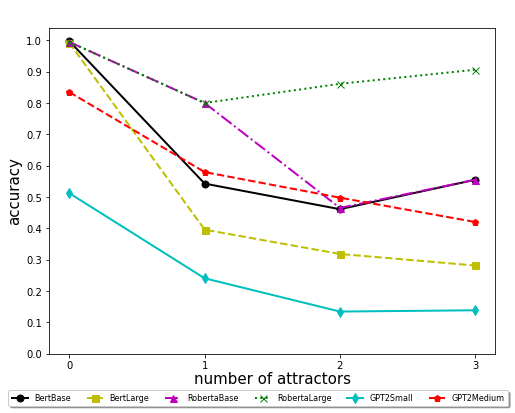

In [81]:
plot_cloze("parents_results.csv", title = ' ', legend = True)
#plot_cloze("marriage_results.csv", title = ' ', legend = False)
#plot_cloze("agecal_results.csv", title = ' ', legend = False)
#plt.legend(["BertBase", "BertLarge", "RobertaBase","RobertaLarge","GPT2Small","GPT2Medium"],
##            loc='upper left', bbox_to_anchor=(-0.2, -0.1), fancybox=True, shadow=True, ncol=6,
 #          fontsize=10)

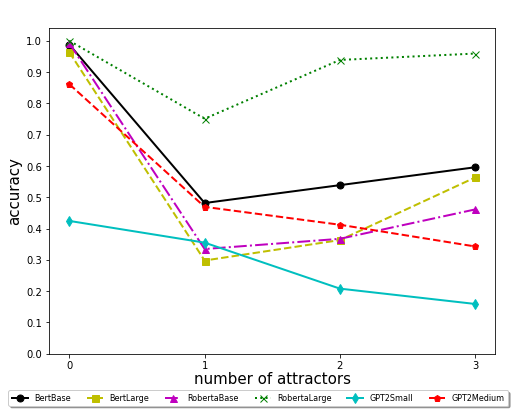

In [82]:
plot_cloze("marriage_results.csv", title = ' ', legend = True)

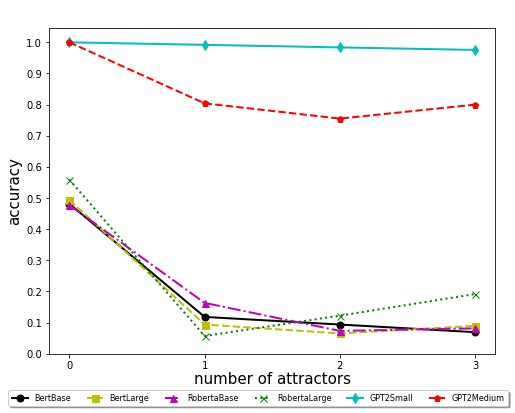

In [83]:
plot_cloze("agecal_results.csv", title = ' ', legend = True)

In [93]:
def main():
    models = ["gpt2"] 
    
    for model in models:
        print(f"{model}:\n" + 100 * '-')
        texts = "Lucas is eighteen years old and Corey is eighteen years old . next year Lucas is nineteen years old , and the age of Corey is"
        tokenizer = GPT2Tokenizer.from_pretrained(model)
        model = GPT2LMHeadModel.from_pretrained(model, pad_token_id=tokenizer.eos_token_id).to(device)
        output = generate(model, texts, tokenizer, n = 1)
        print(output)

    


In [94]:
main()

gpt2:
----------------------------------------------------------------------------------------------------
 nineteen
